# Tomato Leaf Disease Classification
## CSCI 5525 Final Project Fall 2023
#### Tony Zhang

data set: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf

# TomaNet with PyTorch Adam

In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Run this everytime to bring the data into the VM's local storage
# 1. Mount the drive
# 2. Run this cell

!unzip -d /content/tomato-leaf/ /content/drive/MyDrive/UMN/csci5525/project/tomato-leaf.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/tomato-leaf/tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: /content/tomato-leaf/tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: /content/tomato-leaf/tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: /content/tomato-leaf/tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: /content/tomato-leaf/tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: /content/tomato-leaf/tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: /content/tomato-leaf/tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: /content/tomato-lea

In [ ]:
# settings
im_size = 256
# num_epochs = 15
# batch_size = 32
num_epochs = 10
batch_size = 32

In [ ]:
# Transforms
transformer = transforms.Compose([
   transforms.Resize((im_size,im_size)),
   transforms.RandomHorizontalFlip(),
   transforms.RandomVerticalFlip(),
   transforms.ToTensor(),
   transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

In [ ]:
# DataLoader
train_path = '/content/tomato-leaf/tomato/train'
test_path = '/content/tomato-leaf/tomato/val'

train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transformer),
    batch_size=batch_size, shuffle=True
)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transformer),
    batch_size=batch_size, shuffle=True
)

In [ ]:
# categories
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)
print(len(classes))

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
10


In [ ]:
# TomaNet CNN
class TomaNet(nn.Module):
  def __init__(self, num_classes=10):
    super(TomaNet, self).__init__()

    # shape = (batch, 3, 256, 256)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
    # shape = (batch, 12, 256, 256)
    self.bn1 = nn.BatchNorm2d(num_features=12)
    self.relu1 = nn.ReLU()

    self.pool = nn.MaxPool2d(kernel_size=2)
    # shape = (batch, 12, 128, 128)

    self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
    # shape = (batch, 20, 128, 128)
    # self.bn2 = nn.BatchNorm2d(num_features=20)
    self.relu2 = nn.ReLU()

    self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
    # shape = (batch, 32, 128, 128)
    self.bn3 = nn.BatchNorm2d(num_features=32)
    self.relu3 = nn.ReLU()

    self.fc = nn.Linear(in_features=32*128*128, out_features=num_classes)

  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.relu1(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.relu2(output)

    output = self.conv3(output)
    output = self.bn3(output)
    output = self.relu3(output)

    output = output.view(-1, 32*128*128)
    output = self.fc(output)

    return output


In [ ]:
model = TomaNet(num_classes = 10).to(device)

In [ ]:
# Pytorch built in optimizer
optimizer = Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)

In [ ]:
# loss function
loss_function = nn.CrossEntropyLoss()

In [ ]:
train_count = len(glob.glob(train_path + '/**/*.JPG'))
train_count += len(glob.glob(train_path + '/**/*.jpg'))
test_count = len(glob.glob(test_path + '/**/*.JPG'))
test_count += len(glob.glob(test_path + '/**/*.jpg'))
print(train_count, test_count)

9999 1000


In [ ]:
# Model training and saving best model

id = 121223

losses = []

best_accuracy = 0.0

for epoch in range(num_epochs):

  # training phase
  model.train()
  train_accuracy = 0.0
  train_loss = 0.0

  for i, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.cpu().data*images.size(0)
    _, prediction = torch.max(outputs.data, 1)

    train_accuracy += int(torch.sum(prediction == labels.data))

  train_accuracy = train_accuracy/train_count
  train_loss = train_loss/train_count
  losses.append(train_loss)

  # evaluation phase
  model.eval()

  test_accuracy = 0.0
  disease_acc = [["Bacterial Spot", 0.0],
                 ["Early Blight", 0.0],
                 ["Healthy", 0.0],
                 ["Late Blight", 0.0],
                 ["Leaf Mold", 0.0],
                 ["Septoria Leaf Spot", 0.0],
                 ["Spider Mites", 0.0],
                 ["Target Spot", 0.0],
                 ["Mosaic Virus", 0.0],
                 ["Yellow Leaf Curl Virus", 0.0]]

  for i, (images, labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    _,prediction = torch.max(outputs.data, 1)
    test_accuracy += int(torch.sum(prediction == labels.data))

    # print(labels.data)
    for i in range(len(labels.data)):
      disease = int(labels.data[i])
      pred = int(prediction.data[i])
      if pred == disease:
        disease_acc[disease][1] += 0.01 # 100 samples from each class

  test_accuracy = test_accuracy/test_count

  print("Epoch: {}".format(epoch))
  print("train loss: {} train acc: {}".format(train_loss, train_accuracy))
  print("test acc: {}".format(test_accuracy))
  print("disease acc: {}".format(disease_acc))


  # save the best model
  if test_accuracy > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/UMN/csci5525/project/best_checkpoint{}_{}.model'.format(epoch, id))
    best_accuracy = test_accuracy

print(losses)

Epoch: 0
train loss: 25.120328903198242 train acc: 0.5908590859085908
test acc: 0.692
disease acc: [['Bacterial Spot', 0.9600000000000006], ['Early Blight', 0.7000000000000004], ['Healthy', 0.6500000000000004], ['Late Blight', 0.6700000000000004], ['Leaf Mold', 0.6200000000000003], ['Septoria Leaf Spot', 0.8100000000000005], ['Spider Mites', 0.7000000000000004], ['Target Spot', 0.23000000000000007], ['Mosaic Virus', 0.6100000000000003], ['Yellow Leaf Curl Virus', 0.9700000000000006]]
Epoch: 1
train loss: 11.164864540100098 train acc: 0.7533753375337534
test acc: 0.717
disease acc: [['Bacterial Spot', 0.6100000000000003], ['Early Blight', 0.7700000000000005], ['Healthy', 0.8100000000000005], ['Late Blight', 0.36000000000000015], ['Leaf Mold', 0.8900000000000006], ['Septoria Leaf Spot', 0.2900000000000001], ['Spider Mites', 0.8700000000000006], ['Target Spot', 0.9300000000000006], ['Mosaic Virus', 0.7600000000000005], ['Yellow Leaf Curl Virus', 0.8800000000000006]]
Epoch: 2
train loss: 6

# Testing Model on Real Images

In [ ]:
name_to_idx = {'Tomato___Bacterial_spot': 0,
               'Tomato___Early_blight': 1,
               'Tomato___healthy': 2,
               'Tomato___Late_blight': 3,
               'Tomato___Leaf_Mold': 4,
               'Tomato___Septoria_leaf_spot': 5,
               'Tomato___Spider_mites Two-spotted_spider_mite': 6,
               'Tomato___Target_Spot': 7,
               'Tomato___Tomato_mosaic_virus': 8,
               'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 9}

idx_to_name = {0: 'Tomato___Bacterial_spot',
               1: 'Tomato___Early_blight',
               2: 'Tomato___healthy',
               3: 'Tomato___Late_blight',
               4: 'Tomato___Leaf_Mold',
               5: 'Tomato___Septoria_leaf_spot',
               6: 'Tomato___Spider_mites Two-spotted_spider_mite',
               7: 'Tomato___Target_Spot',
               8: 'Tomato___Tomato_mosaic_virus',
               9: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'}

In [ ]:
model = TomaNet(num_classes = 10).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/UMN/csci5525/project/best_checkpoint9_121223.model"))

<All keys matched successfully>

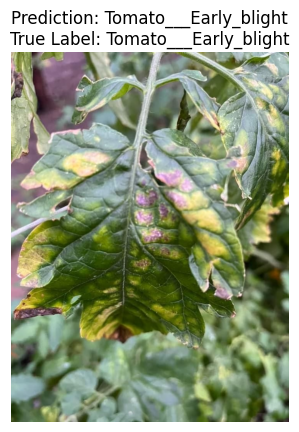

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# image_path = "/content/drive/MyDrive/UMN/csci5525/project/real_multi_leaf.jpg"
# label = 2

# image_path = "/content/drive/MyDrive/UMN/csci5525/project/real_diseased_cropped.jpg"
# label = 0

image_path = "/content/drive/MyDrive/UMN/csci5525/project/real_multi_depth.jpg"
label = 1

model.eval()

im = Image.open(image_path)

im_size = 256
test_transformer = transforms.Compose([
   transforms.Resize((im_size,im_size)),
   transforms.ToTensor(),
   transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

im = test_transformer(im)
im = torch.reshape(im, (1, im.shape[0], im.shape[1], im.shape[2]))

if torch.cuda.is_available():
      im = Variable(im.cuda())

outputs = model(im)
_,prediction = torch.max(outputs.data, 1)
prediction = int(prediction)

img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title("Prediction: {}\nTrue Label: {}".format(idx_to_name[prediction], idx_to_name[label]))
plt.show()

# TomaNet with Custom Adam

In [ ]:
import numpy as np
import torch
from torch.optim import Optimizer

class MyAdam(Optimizer):
  def __init__(self, parameters, lr=1e-3, b1=0.9, b2 = 0.999, lam = 0.0001, e=1e-8):
    defaults = {"lr": lr}
    super().__init__(parameters, defaults)
    self.b1 = b1
    self.b2 = b2
    self.lam = lam
    self.e = e

    self.state = dict()

    for group in self.param_groups:
      for p in group['params']:
        self.state[p] = dict()
        state = self.state[p]
        state["step"] = 0
        state["moment1"] = torch.zeros_like(p.data) # first moment
        state["moment2"] = torch.zeros_like(p.data) # second moment

  def step(self):

    # loop over parameter groups
    for group in self.param_groups:
      # loop over parameters
      for p in group['params']:

        # grab parameter gradient
        if p.grad is None:
          continue
        g = p.grad.data + self.lam * p.data

        # grab state variables
        state = self.state[p]
        moment1 = state["moment1"]
        moment2 = state["moment2"]

        # update state variables
        state["step"] += 1
        # exponential moving average
        moment1 = (moment1 * self.b1) + ((1 - self.b1) * g)
        # exponential moving squared average
        moment2 = (moment2 * self.b2) + ((1 - self.b2) * g * g)

        # correct bias
        moment1_corr = moment1 / (1 - self.b1 ** state["step"])
        moment2_corr = moment2 / (1 - self.b2 ** state["step"])
        # add epsilon
        moment2_corr.add_(self.e)
        # take square root of 2nd moment
        moment2_corr = torch.sqrt(moment2_corr)

        # compute search direction
        d = moment1_corr / moment2_corr
        a = group["lr"]

        # update parameter
        p.data.add_(-1 * a * d)

In [ ]:
model = TomaNet(num_classes = 10).to(device)
optimizer = MyAdam(model.parameters())
loss_function = nn.CrossEntropyLoss()

In [ ]:
# Model training and saving best model

id = np.random.randint(0,10000)

losses = []

best_accuracy = 0.0

for epoch in range(num_epochs):

  # training phase
  model.train()
  train_accuracy = 0.0
  train_loss = 0.0

  for i, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.cpu().data*images.size(0)
    _, prediction = torch.max(outputs.data, 1)

    train_accuracy += int(torch.sum(prediction == labels.data))

  train_accuracy = train_accuracy/train_count
  train_loss = train_loss/train_count
  losses.append(train_loss)

  # evaluation phase
  model.eval()

  test_accuracy = 0.0
  disease_acc = [["Bacterial Spot", 0.0],
                 ["Early Blight", 0.0],
                 ["Healthy", 0.0],
                 ["Late Blight", 0.0],
                 ["Leaf Mold", 0.0],
                 ["Septoria Leaf Spot", 0.0],
                 ["Spider Mites", 0.0],
                 ["Target Spot", 0.0],
                 ["Mosaic Virus", 0.0],
                 ["Yellow Leaf Curl Virus", 0.0]]

  for i, (images, labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    _,prediction = torch.max(outputs.data, 1)
    test_accuracy += int(torch.sum(prediction == labels.data))

    # print(labels.data)
    for i in range(len(labels.data)):
      disease = int(labels.data[i])
      pred = int(prediction.data[i])
      if pred == disease:
        disease_acc[disease][1] += 0.01 # 100 samples from each class

  test_accuracy = test_accuracy/test_count

  print("Epoch: {}".format(epoch))
  print("train loss: {} train acc: {}".format(train_loss, train_accuracy))
  print("test acc: {}".format(test_accuracy))
  print("disease acc: {}".format(disease_acc))


  # # save the best model
  # if test_accuracy > best_accuracy:
  #   torch.save(model.state_dict(), '/content/drive/MyDrive/UMN/csci5525/project/best_checkpoint{}_{}.model'.format(epoch, id))
  #   best_accuracy = test_accuracy

print(losses)

Epoch: 0
train loss: 57.43058776855469 train acc: 0.44414441444144415
test acc: 0.731
disease acc: [['Bacterial Spot', 0.6300000000000003], ['Early Blight', 0.8400000000000005], ['Healthy', 0.6300000000000003], ['Late Blight', 0.7900000000000005], ['Leaf Mold', 0.3200000000000001], ['Septoria Leaf Spot', 0.7300000000000004], ['Spider Mites', 0.8300000000000005], ['Target Spot', 0.6100000000000003], ['Mosaic Virus', 0.9600000000000006], ['Yellow Leaf Curl Virus', 0.9700000000000006]]
Epoch: 1
train loss: 24.61494255065918 train acc: 0.6102610261026102
test acc: 0.586
disease acc: [['Bacterial Spot', 0.3000000000000001], ['Early Blight', 0.5800000000000003], ['Healthy', 0.7100000000000004], ['Late Blight', 0.05], ['Leaf Mold', 0.8600000000000005], ['Septoria Leaf Spot', 0.20000000000000004], ['Spider Mites', 0.6700000000000004], ['Target Spot', 0.9200000000000006], ['Mosaic Virus', 0.8600000000000005], ['Yellow Leaf Curl Virus', 0.7100000000000004]]
Epoch: 2
train loss: 4.892112731933594

# Random Forest

In [ ]:
# Run this everytime to bring the data into the VM's local storage
# 1. Mount the drive
# 2. Run this cell

!unzip -d /content/tomato-leaf/ /content/drive/MyDrive/UMN/csci5525/project/tomato-leaf.zip

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# set up train data set
train_path = '/content/tomato-leaf/tomato/train'
X_train = []
y_train = []

for folder_name in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder_name)

    if os.path.isdir(folder_path):
        label = folder_name

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # read in image and resize
            image = cv2.imread(file_path)
            image = cv2.resize(image, (256, 256))

            # flatten to 1d
            flattened_image = image.flatten()

            X_train.append(flattened_image)
            y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# set up test data set
test_path = '/content/tomato-leaf/tomato/val'
X_test = []
y_test = []

for folder_name in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder_name)

    if os.path.isdir(folder_path):
        label = folder_name

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # read in image and resize
            image = cv2.imread(file_path)
            image = cv2.resize(image, (256, 256))

            # flatten to 1d
            flattened_image = image.flatten()

            X_test.append(flattened_image)
            y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# initialize model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# fit model
rf_classifier.fit(X_train, y_train)

# get predictions
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.61

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.63      0.83      0.72       100
                        Tomato___Early_blight       0.45      0.40      0.43       100
                         Tomato___Late_blight       0.74      0.54      0.62       100
                           Tomato___Leaf_Mold       0.62      0.55      0.59       100
                  Tomato___Septoria_leaf_spot       0.52      0.57      0.55       100
Tomato___Spider_mites Two-spotted_spider_mite       0.48      0.59      0.53       100
                         Tomato___Target_Spot       0.51      0.46      0.48       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.71      0.79      0.75       100
                 Tomato___Tomato_mosaic_virus       0.63      0.69      0.66       100
                             Tomato___healthy       0.86      0.66      0.75       100

  

In [ ]:
name_to_idx = {'Tomato___Bacterial_spot': 0,
               'Tomato___Early_blight': 1,
               'Tomato___healthy': 2,
               'Tomato___Late_blight': 3,
               'Tomato___Leaf_Mold': 4,
               'Tomato___Septoria_leaf_spot': 5,
               'Tomato___Spider_mites Two-spotted_spider_mite': 6,
               'Tomato___Target_Spot': 7,
               'Tomato___Tomato_mosaic_virus': 8,
               'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 9}

In [ ]:
disease_acc = [["Bacterial Spot", 0.0],
                 ["Early Blight", 0.0],
                 ["Healthy", 0.0],
                 ["Late Blight", 0.0],
                 ["Leaf Mold", 0.0],
                 ["Septoria Leaf Spot", 0.0],
                 ["Spider Mites", 0.0],
                 ["Target Spot", 0.0],
                 ["Mosaic Virus", 0.0],
                 ["Yellow Leaf Curl Virus", 0.0]]

for i in range(len(y_test)):
  label = name_to_idx[y_test[i]]
  pred = name_to_idx[y_pred[i]]
  if label == pred:
    disease_acc[label][1] += 0.01

print(disease_acc)

[['Bacterial Spot', 0.8300000000000005], ['Early Blight', 0.4000000000000002], ['Healthy', 0.6600000000000004], ['Late Blight', 0.5400000000000003], ['Leaf Mold', 0.5500000000000003], ['Septoria Leaf Spot', 0.5700000000000003], ['Spider Mites', 0.5900000000000003], ['Target Spot', 0.46000000000000024], ['Mosaic Virus', 0.6900000000000004], ['Yellow Leaf Curl Virus', 0.7900000000000005]]


# Logistic Regression

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

# initialize model
num_classes = 10
im_size = 256
input_size = im_size * im_size * 3  # Adjust based on the size of your input images
model = LogisticRegressionModel(input_size, num_classes).to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# training loop
num_epochs = 10

for epoch in range(num_epochs):

    # training phase
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for images, labels in train_loader:

        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        images = images.view(-1, input_size).float()

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data*images.size(0)
        _, prediction = torch.max(outputs.data, 1)

    train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count

    # evaluation phase
    model.eval()

    test_accuracy = 0.0
    disease_acc = [["Bacterial Spot", 0.0],
                  ["Early Blight", 0.0],
                  ["Healthy", 0.0],
                  ["Late Blight", 0.0],
                  ["Leaf Mold", 0.0],
                  ["Septoria Leaf Spot", 0.0],
                  ["Spider Mites", 0.0],
                  ["Target Spot", 0.0],
                  ["Mosaic Virus", 0.0],
                  ["Yellow Leaf Curl Virus", 0.0]]

    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        images = images.view(-1, input_size).float()

        outputs = model(images)
        _,prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))

        for i in range(len(labels.data)):
            disease = int(labels.data[i])
            pred = int(prediction.data[i])
            if pred == disease:
                disease_acc[disease][1] += 0.01 # 100 samples from each class

    test_accuracy = test_accuracy/test_count

    print("Epoch: {}".format(epoch))
    print("train loss: {} train acc: {}".format(train_loss, train_accuracy))
    print("test acc: {}".format(test_accuracy))
    print("disease acc: {}".format(disease_acc))

Epoch: 0
train loss: 1.9571040868759155 train acc: 0.0006000600060006001
test acc: 0.467
disease acc: [['Bacterial Spot', 0.4100000000000002], ['Early Blight', 0.46000000000000024], ['Healthy', 0.18000000000000002], ['Late Blight', 0.47000000000000025], ['Leaf Mold', 0.6400000000000003], ['Septoria Leaf Spot', 0.5900000000000003], ['Spider Mites', 0.49000000000000027], ['Target Spot', 0.4100000000000002], ['Mosaic Virus', 0.5200000000000002], ['Yellow Leaf Curl Virus', 0.5000000000000002]]
Epoch: 1
train loss: 1.8733527660369873 train acc: 0.0009000900090009
test acc: 0.514
disease acc: [['Bacterial Spot', 0.35000000000000014], ['Early Blight', 0.6200000000000003], ['Healthy', 0.20000000000000004], ['Late Blight', 0.45000000000000023], ['Leaf Mold', 0.5400000000000003], ['Septoria Leaf Spot', 0.5600000000000003], ['Spider Mites', 0.38000000000000017], ['Target Spot', 0.6600000000000004], ['Mosaic Virus', 0.8000000000000005], ['Yellow Leaf Curl Virus', 0.5800000000000003]]
Epoch: 2
trai